**Tổng Quan**
---
---
*Đề Tài (Topic)*
  - Xây dựng mô hình dự đoán giá vàng

*Dữ liệu (Dataset)*
  - Dataset giá vàng Việt Nam được lấy từ Kaggle đây là một trong những cộng đồng, một nền tảng lớn uy tín về Dataset.
  - Dữ liệu ban đầu: 19 Cột,
  - Quá trình xử lí dữ liệu:
    + Tách Cột 'Date','Price (VND)' ra khỏi bảng dữ liệu chính sau đó chọn lọc data trong khoảng thời gian từ ngày 01-01-2002 đến ngày 08-04-2022.

*Mô hình (Model)*
  - Mô hình sử dụng thuật toán học sâu có giám sát LSTM (Long Short-Term Memory) đây là dạng đặc biệt của RNN, cũng có thể nói là một mô hình cải tiến từ RNN nhằm giải quyết các bước nhớ dài của RNN.


**IMPORT LIBRARY**
---
---


In [33]:
#Prepare and process data
import math
import pandas as pd #read data file csv
import matplotlib.pyplot as plt #draw chart
import matplotlib.ticker as ticker #Format
import numpy as np #data processing
from keras.callbacks import ModelCheckpoint #keep good training
from tensorflow.keras.models import load_model #download model
from sklearn.preprocessing import MinMaxScaler #normalize data 0->1
#Training, model building
from keras.models import Sequential #input
from keras.layers import Dropout #avoid overfitting
from keras.layers import LSTM #dependent learning
from keras.layers import Dense #output
#Phân tích chỉ số
from sklearn.metrics import r2_score #measure suitability
from sklearn.metrics import mean_squared_error #measure MSE and RMSE = sqrt(MSE)
from sklearn. metrics import mean_absolute_error #measure mean absolute error
from sklearn.metrics import mean_absolute_percentage_error #measure the mean percent absolute error

**READ DATA**
---
---

In [34]:
#Kết nội google colab với drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
#Proceed to read csv data using pandas library with the command pd.read_csv
df=pd.read_csv('/content/drive/MyDrive/Probability-Statistic/LAB3/Team5-PAPERREPORT/Data/DATA(2002-2022).csv')
df

,Date,Prices
0,2002-01-01,4170449.50
1,2002-01-02,4198629.19
2,2002-01-03,4206113.25
3,2002-01-04,4190692.00
4,2002-01-07,4203514.59
...,...,...
5284,2022-04-04,44102530.37
5285,2022-04-05,44470144.87
5286,2022-04-06,44137702.89
5287,2022-04-07,44176594.17


In [36]:
df.info() #check formatted data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5289 entries, 0 to 5288
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5289 non-null   object 
 1   Prices  5289 non-null   float64
dtypes: float64(1), object(1)
memory usage: 82.8+ KB


**ĐỊNH DẠNG CẤU TRÚC DỮ LIỆU**
---
---


In [37]:
#Reformat the structure of the Date column (year-month-day format)
df["Date"]=pd.to_datetime(df.Date,format="%Y/%m/%d")

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5289 entries, 0 to 5288
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5289 non-null   datetime64[ns]
 1   Prices  5289 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 82.8 KB


In [39]:
df=pd.DataFrame(df,columns=['Date','Prices'])
df.index=df.Date
df.drop("Date",axis=1, inplace=True)

In [40]:
df.head(7) # kiểm tra 7 dòng đầu tiên

,Prices
Date,
2002-01-01,4170449.50
2002-01-02,4198629.19
2002-01-03,4206113.25
2002-01-04,4190692.00
2002-01-07,4203514.59
2002-01-08,4204907.59
2002-01-09,4244045.59


**SƠ ĐỒ DỮ LIỆU SAU KHI XỬ LÍ VÀ ĐỊNH DẠNG**
---
---
* Vẽ dựa theo giá vàng trong quá khứ
---

In [41]:

# #Kích thước biểu đồ với chiều ngang là 17 và dọc là 5
# plt.figure(figsize=(17,5))
# #Lập biểu đồ với dữ liệu là Prices đặt tên nhãn là Gold Prices và màu line là đỏ
# plot = plt.plot(df['Prices'], label='Gold Prices', color='red')
# #Đặt tên biểu đồ là Plot Gold Prices
# plt.title('Plot Gold Prices')
# #Đặt tên cột x là Days
# plt.xlabel('Days')
# #Đặt tên cột y là Price(VND)
# plt.ylabel('Prices (VND)')
# #Thêm chú thích
# plt.legend()
# #Hiển thị sơ đồ
# # plot.set_major_formatter(format)


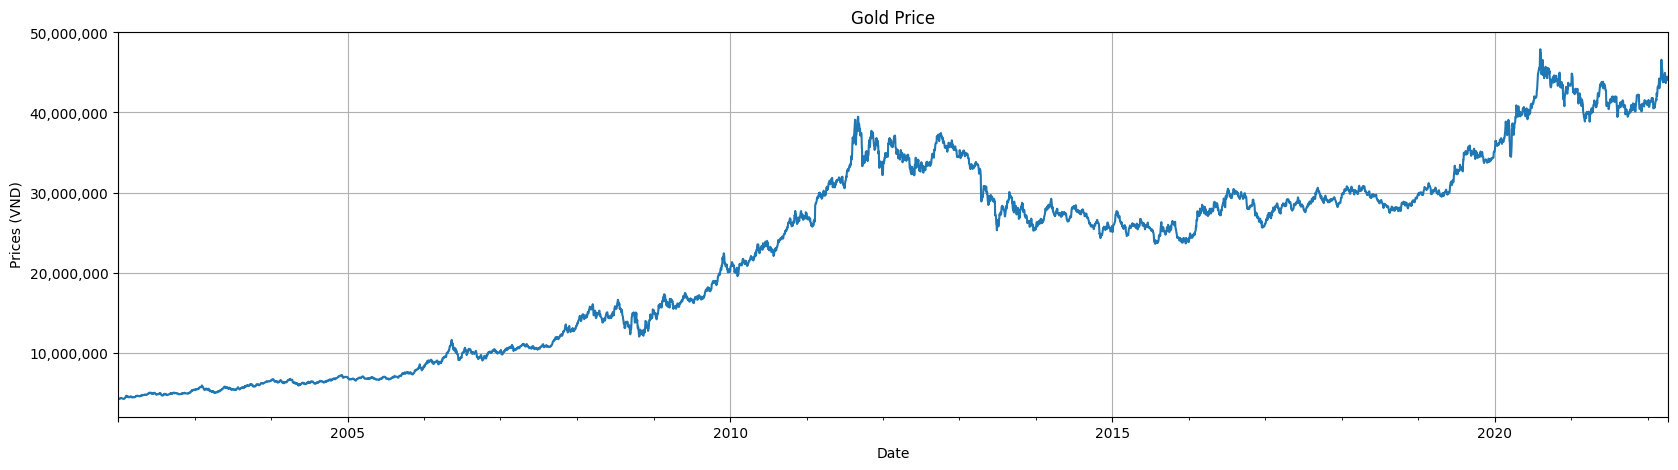

In [42]:
#Draw plot
format = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Gold Price'
ylabel = 'Prices (VND)'
xlabel = 'Date'
plot = df['Prices'].plot(figsize=(20, 5), title=title)
plot.autoscale(axis='x', tight=True)
plot.set(xlabel=xlabel, ylabel=ylabel)
plot.yaxis.set_major_formatter(format)
plot.grid(True)
plt.show()


**CHỌN VÙNG DỮ LIỆU TRAIN VÀ TEST**
---
---
  - Lần 1
* 80% Dữ liệu đầu tiên dùng train
* 20% dữ liệu sau đó dùng test
  - Lần 2
* 70% Dữ liệu đầu tiên dùng train
* 30% dữ liệu sau đó dùng test
  - Lần 3
* 90% Dữ liệu đầu tiên dùng train
* 10% dữ liệu sau đó dùng test

In [43]:
df.shape #kiểm tra số dòng của dữ liệu

(5289, 1)

In [44]:
#.values
# Return a Numpy representation of the DataFrame.
# Only the values in the DataFrame will be returned, the axes labels will be removed.
df.values

array([[ 4170449.5 ],
       [ 4198629.19],
       [ 4206113.25],
       ...,
       [44137702.89],
       [44176594.17],
       [44384284.57]])

In [45]:
#train 8 - 2
# data=df.values
# train_data=data[:2979]
# test_data=data[2979:]
#2002-2022
#Tiến hành chia dữ liệu train / test
# data=df.values
# #Tập train sẽ lấy 80%
# train_data=data[:4231]
# #Tập test sẽ lấy 20%
# test_data=data[4231:]


In [46]:
# divided dataste 80% train - 20% test
data=df.values
training_data_len = math.ceil(len(data)* 0.8)
train_data = data[0: training_data_len, :]
train_data.shape
test_data=data[training_data_len:]
test_data.shape

(1057, 1)

In [47]:
#train 7 - 3
# train_data73=data[:2606]
# test_data73=data[2606:]
#2002-2022
#Tập train sẽ lấy 70%
# train_data73=data[:3702]
# #Tập test sẽ lấy 30%
# test_data73=data[3702:]

In [48]:
# divided dataste 70% train - 30% test
training_data_len73 = math.ceil(len(data)* 0.7)
train_data73 = data[0: training_data_len73, :]
train_data73.shape
test_data73=data[training_data_len73:]
test_data73.shape

(1586, 1)

In [49]:
#train 9 - 1
# train_data91=data[:3351]
# test_data91=data[3351:]
#2002-2022
#Tập train sẽ lấy 90%
# train_data91=data[:4760]
# #Tập test sẽ lấy 10%
# test_data91=data[4760:]

In [50]:
# divided dataste 90% train - 10% test
training_data_len91 = math.ceil(len(data)* 0.9)
train_data91 = data[0: training_data_len91, :]
train_data91.shape
test_data91=data[training_data_len91:]
test_data91.shape

(528, 1)

**CHUẨN HOÁ DỮ LIỆU**
---
---

In [51]:
#Re-normalize the data with the values ​​returned from 0-1
sc=MinMaxScaler(feature_range=(0,1))
#Normalize data named data
sc_train=sc.fit_transform(data)

In [52]:
#Check data after normalization
sc_train

array([[0.00000000e+00],
       [6.44347526e-04],
       [8.15475581e-04],
       ...,
       [9.13878074e-01],
       [9.14767349e-01],
       [9.19516330e-01]])

**XỬ LÍ DỮ LIỆU TẬP TRAIN**
---
---

In [53]:
# 8-2
#Declare 2 data arrays x_train and y_train
x_train,y_train=[],[]
for i in range(15,len(train_data)):
  x_train.append(sc_train[i-15:i,0]) #.append assign the element to the end of the array,
  #because the number of days it will learn to predict the next 1 day is 15 so -15
  #(each array includes 6 days price)
  y_train.append(sc_train[i,0])


In [54]:
x_train

[array([0.        , 0.00064435, 0.00081548, 0.00046286, 0.00075606,
        0.00078791, 0.00168282, 0.00366787, 0.00328491, 0.00352145,
        0.00277905, 0.00293016, 0.00308139, 0.00245964, 0.00218099]),
 array([0.00064435, 0.00081548, 0.00046286, 0.00075606, 0.00078791,
        0.00168282, 0.00366787, 0.00328491, 0.00352145, 0.00277905,
        0.00293016, 0.00308139, 0.00245964, 0.00218099, 0.00208171]),
 array([0.00081548, 0.00046286, 0.00075606, 0.00078791, 0.00168282,
        0.00366787, 0.00328491, 0.00352145, 0.00277905, 0.00293016,
        0.00308139, 0.00245964, 0.00218099, 0.00208171, 0.00163266]),
 array([0.00046286, 0.00075606, 0.00078791, 0.00168282, 0.00366787,
        0.00328491, 0.00352145, 0.00277905, 0.00293016, 0.00308139,
        0.00245964, 0.00218099, 0.00208171, 0.00163266, 0.0011195 ]),
 array([0.00075606, 0.00078791, 0.00168282, 0.00366787, 0.00328491,
        0.00352145, 0.00277905, 0.00293016, 0.00308139, 0.00245964,
        0.00218099, 0.00208171, 0.001632

In [55]:
x_train=np.array(x_train) # sort data into an array
y_train=np.array(y_train)
x_train=np.reshape(x_train,(x_train.shape[0], x_train.shape[1],1)) # Process data into a one-dimensional array
y_train=np.reshape(y_train,(y_train.shape[0],1))

In [56]:
x_train

array([[[0.00000000e+00],
        [6.44347526e-04],
        [8.15475581e-04],
        ...,
        [3.08138928e-03],
        [2.45963647e-03],
        [2.18099288e-03]],

       [[6.44347526e-04],
        [8.15475581e-04],
        [4.62858349e-04],
        ...,
        [2.45963647e-03],
        [2.18099288e-03],
        [2.08171357e-03]],

       [[8.15475581e-04],
        [4.62858349e-04],
        [7.56055476e-04],
        ...,
        [2.18099288e-03],
        [2.08171357e-03],
        [1.63266037e-03]],

       ...,

       [[5.98105158e-01],
        [5.94302251e-01],
        [5.90388420e-01],
        ...,
        [5.93641919e-01],
        [5.91173433e-01],
        [5.86580348e-01]],

       [[5.94302251e-01],
        [5.90388420e-01],
        [5.84938553e-01],
        ...,
        [5.91173433e-01],
        [5.86580348e-01],
        [5.87852605e-01]],

       [[5.90388420e-01],
        [5.84938553e-01],
        [5.92824911e-01],
        ...,
        [5.86580348e-01],
        [5.8785

In [57]:
# 7-3
x_train73,y_train73=[],[]
for i in range(15,len(train_data73)):
  x_train73.append(sc_train[i-15:i,0])
  y_train73.append(sc_train[i,0])

In [58]:
x_train73=np.array(x_train73)
y_train73=np.array(y_train73)

x_train73=np.reshape(x_train73,(x_train73.shape[0], x_train73.shape[1],1))
y_train73=np.reshape(y_train73,(y_train73.shape[0],1))

In [59]:
# 9-1
x_train91,y_train91=[],[]
for i in range(15,len(train_data91)):
  x_train91.append(sc_train[i-15:i,0])
  y_train91.append(sc_train[i,0])

In [60]:
x_train91=np.array(x_train91)
y_train91=np.array(y_train91)

x_train91=np.reshape(x_train91,(x_train91.shape[0], x_train91.shape[1],1))
y_train91=np.reshape(y_train91,(y_train91.shape[0],1))

**HUẤN LUYỆN MÔ HÌNH**
---
---


In [61]:
# 8-2
#Xây dựng mô hình
model=Sequential() #input, create a list that stores lists (list)
model.add(LSTM(units=64, input_shape=(x_train.shape[1],1) ,return_sequences=True))
# create LSTM layer - describe input information
model.add(Dropout(0.2))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=32))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dropout(0.5)) #Avoid memorization
#(used to assume that part of the units is hidden during training, thereby reducing the blending product)
model.add(Dense(1)) #One-way output for forecasting a value (output direction)
model.compile(loss='mean_absolute_error', optimizer='adam')
# mean_absolute_error: used to evaluate the difference between the predictive model and the testing dataset.
# adam: used to optimize the learning speed
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 15, 64)            16896     
                                                                 
 dropout_4 (Dropout)         (None, 15, 64)            0         
                                                                 
 lstm_4 (LSTM)               (None, 15, 64)            33024     
                                                                 
 dropout_5 (Dropout)         (None, 15, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 25)               

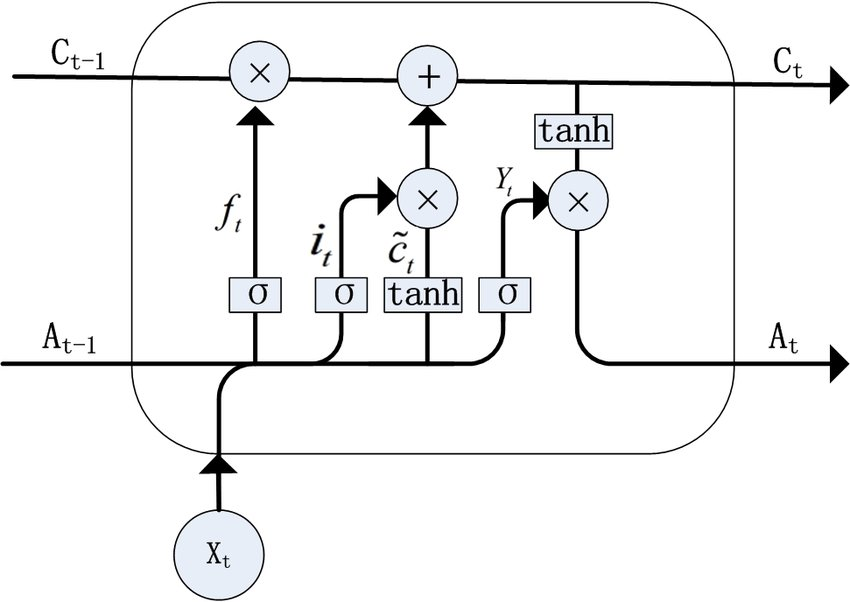

In [ ]:

# model model training
save_model="save_model.h5" #save the model as file .h5
best_model=ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True, mode='auto')
# find the best model, save_best_only: save the best model
model.fit(x_train,y_train, epochs=100,verbose=2,callbacks=best_model)

Epoch 1/100

Epoch 1: loss improved from inf to 0.09246, saving model to save_model.h5
132/132 - 10s - loss: 0.0925 - 10s/epoch - 78ms/step
Epoch 2/100

Epoch 2: loss improved from 0.09246 to 0.06423, saving model to save_model.h5
132/132 - 3s - loss: 0.0642 - 3s/epoch - 24ms/step
Epoch 3/100

Epoch 3: loss improved from 0.06423 to 0.05885, saving model to save_model.h5
132/132 - 5s - loss: 0.0589 - 5s/epoch - 35ms/step
Epoch 4/100

Epoch 4: loss improved from 0.05885 to 0.05514, saving model to save_model.h5
132/132 - 3s - loss: 0.0551 - 3s/epoch - 26ms/step
Epoch 5/100


In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(loss_per_epoch)

In [ ]:
# 7-3
#Xây dựng mô hình
model73=Sequential()
#128
model73.add(LSTM(units=64, input_shape=(x_train73.shape[1],1),return_sequences=True))
model73.add(Dropout(0.5))
model73.add(LSTM(units=64, return_sequences=True))
model73.add(Dropout(0.5))
model73.add(LSTM(units=32))
model73.add(Dropout(0.5))
model73.add(Dense(25))
model73.add(Dropout(0.5))
# Tránh việc học thuộc
model73.add(Dense(1))
model73.compile(loss='mean_absolute_error', optimizer='adam')

In [ ]:
#thực thi mô hình
save_model73="save_model73.h5"
best_model73=ModelCheckpoint(save_model73,monitor='loss',verbose=2,save_best_only=True, mode='auto')
model73.fit(x_train73,y_train73, epochs=100,verbose=2,callbacks=best_model73) # callbacks lưu dữ liệu phần epochs có loss thấp nhất
# model.fit(x_train, y_train, batch_size= 32, epochs=30)

In [ ]:
loss_per_epoch = model73.history.history['loss']
plt.plot(loss_per_epoch)

In [ ]:
# 9-1
#Xây dựng mô hình
model91=Sequential()
#unit Số nguyên dương, chiều của không gian đầu ra.
model91.add(LSTM(units=64, input_shape=(x_train91.shape[1],1),return_sequences=True))
model91.add(Dropout(0.5))
model91.add(LSTM(units=64, return_sequences=True))
model91.add(Dropout(0.5))
model91.add(LSTM(units=32))
model91.add(Dropout(0.5))
model91.add(Dense(25))
model91.add(Dropout(0.5))
model91.add(Dense(1))
model91.compile(loss='mean_absolute_error', optimizer='adam')

In [ ]:
#thực thi mô hình
save_model91="save_model91.h5"
best_model91=ModelCheckpoint(save_model91,monitor='loss',verbose=2,save_best_only=True, mode='auto')
model91.fit(x_train91,y_train91, epochs=100,verbose=2,callbacks=best_model91) #lưu dữ liệu phần epochs có loss thấp nhất
# model.fit(x_train, y_train, batch_size= 32, epochs=30)

In [ ]:
loss_per_epoch = model91.history.history['loss']
plt.plot(loss_per_epoch)

**ĐIỀU CHỈNH ĐỊNH DẠNG DỮ LIỆU TỪ DỮ LIỆU ĐÃ CHUẨN HOÁ SANG (0->1) SANG VND**




---


In [ ]:
y_train=sc.inverse_transform(y_train) #Proceed to process the normalized number 0-1 into the price of gold VND
final_model=load_model('save_model.h5') #reload the best model saved
y_train_predict=final_model.predict(x_train) #predicted price
y_train_predict=sc.inverse_transform(y_train_predict)
#proceed to process the normalized number 0-1 into the predicted gold price VND

In [ ]:
# 7-3
y_train73=sc.inverse_transform(y_train73)
final_model73=load_model('save_model73.h5')
y_train_predict73=final_model73.predict(x_train73)
y_train_predict73=sc.inverse_transform(y_train_predict73)

In [ ]:
# 9-1
y_train91=sc.inverse_transform(y_train91)
final_model91=load_model('save_model91.h5')
y_train_predict91=final_model91.predict(x_train91)
y_train_predict91=sc.inverse_transform(y_train_predict91)

**XỬ LÍ DỮ LIỆU TẬP TEST**
---
---

In [ ]:
test=df[len(train_data)-15:].values
test=test.reshape(-1,1)
sc_test=sc.transform(test)

x_test=[]
for i in range(15,test.shape[0]):
  x_test.append(sc_test[i-15:i,0])
x_test=np.array(x_test)
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

y_test=data[training_data_len:]
y_test_predict=final_model.predict(x_test)
y_test_predict=sc.inverse_transform(y_test_predict)

In [ ]:
# 7-3
test73=df[len(train_data73)-15:].values
test73=test73.reshape(-1,1)
sc_test73=sc.transform(test73)

x_test73=[]
for i in range(15,test73.shape[0]):
  x_test73.append(sc_test73[i-15:i,0])
x_test73=np.array(x_test73)
x_test73=np.reshape(x_test73,(x_test73.shape[0],x_test73.shape[1],1))

# y_test73=data[2606:]
#2002-2022
# y_test73=data[3702:]
y_test73=data[training_data_len73:]
y_test_predict73=final_model73.predict(x_test73)
y_test_predict73=sc.inverse_transform(y_test_predict73)

In [ ]:
# 9-1
test91=df[len(train_data91)-15:].values
test91=test91.reshape(-1,1)
sc_test91=sc.transform(test91)

x_test91=[]
for i in range(15,test91.shape[0]):
  x_test91.append(sc_test91[i-15:i,0])
x_test91=np.array(x_test91)
x_test91=np.reshape(x_test91,(x_test91.shape[0],x_test91.shape[1],1))

# y_test91=data[3351:]
#2002-2022
# y_test91=data[4760:]
y_test91=data[training_data_len91:]
y_test_predict91=final_model91.predict(x_test91)
y_test_predict91=sc.inverse_transform(y_test_predict91)

**VẼ BIỂU ĐỒ VỚI GIÁ TRỊ DỰ ĐOÁN SAU KHI TRAIN**
---
---
* Dữ liệu train
* Dữ liệu test
* Dữ liệu dự đoán
---

In [ ]:
train_datal=df[15:training_data_len]
test_datal=df[training_data_len:]
format = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Gold Price'
ylabel = 'Prices (VND)'
xlabel = 'Date'
plt.figure(figsize=(21,5))
plot = df['Prices'].plot(label=f"Prices Data",color='red')
train_datal['prediction']=y_train_predict
plot_pdtrain = train_datal['prediction'].plot(label=f"Prediction train", color='green')
test_datal['prediction']=y_test_predict
plot_pdtest = test_datal['prediction'].plot(label=f"Prediction test", color='blue')

plot.autoscale(axis='x', tight=True)
plot.set(xlabel=xlabel, ylabel=ylabel)
plot.yaxis.set_major_formatter(format)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#7-3
# train_datal73=df[60:2606]
# test_datal73=df[2606:]
#2002-2022
# train_datal73=df[30:3702]
# test_datal73=df[3702:]

# plt.figure(figsize=(17,5))
# plt.plot(df,label='Prices Data',color='red')
# train_datal73['prediction']=y_train_predict73
# plt.plot(train_datal73['prediction'],label='Prediction train', color='green')
# test_datal73['prediction']=y_test_predict73
# plt.plot(test_datal73['prediction'],label='Prediction test', color='blue')

# plt.title('Plot Gold Prices')
# plt.xlabel('Year')
# plt.ylabel('Prices (VND)')
# plt.legend()
# plt.show()

In [ ]:
# train_datal73=df[30:3702]
# test_datal73=df[3702:]
train_datal73=df[15:training_data_len73]
test_datal73=df[training_data_len73:]


format = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Gold Prices Train 7 - Test 3'
ylabel = 'Prices (VND)'
xlabel = 'Date'
plt.figure(figsize=(21,5))
plot = df['Prices'].plot(label=f"Prices Data",color='red')
train_datal73['prediction']=y_train_predict73
plot_pdtrain = train_datal73['prediction'].plot(label=f"Prediction train", color='green')
test_datal73['prediction']=y_test_predict73
plot_pdtest = test_datal73['prediction'].plot(label=f"Prediction test", color='blue')

plot.autoscale(axis='x', tight=True)
plot.set(xlabel=xlabel, ylabel=ylabel)
plot.yaxis.set_major_formatter(format)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#9-1
# train_datal91=df[60:3351]
# test_datal91=df[3351:]
#2002-2022
# train_datal91=df[30:4760]
# test_datal91=df[4760:]

# plt.figure(figsize=(17,5))
# plt.plot(df,label='Prices Data',color='red')
# train_datal91['prediction']=y_train_predict91
# plt.plot(train_datal91['prediction'],label='Prediction train', color='green')
# test_datal91['prediction']=y_test_predict91
# plt.plot(test_datal91['prediction'],label='Prediction test', color='blue')

# plt.title('Plot Gold Prices')
# plt.xlabel('Year')
# plt.ylabel('Prices (VND)')
# plt.legend()
# plt.show()

In [ ]:
# train_datal91=df[30:4760]
# test_datal91=df[4760:]
train_datal91=df[15:training_data_len91]
test_datal91=df[training_data_len91:]

format = ticker.StrMethodFormatter('{x:,.0f}')
title = 'Gold Prices'
ylabel = 'Prices (VND)'
xlabel = 'Date'
plt.figure(figsize=(21,5))
plot = df['Prices'].plot(label=f"Prices Data",color='red')
train_datal91['prediction']=y_train_predict91
plot_pdtrain = train_datal91['prediction'].plot(label=f"Prediction train", color='green')
test_datal91['prediction']=y_test_predict91
plot_pdtest = test_datal91['prediction'].plot(label=f"Prediction test", color='blue')

plot.autoscale(axis='x', tight=True)
plot.set(xlabel=xlabel, ylabel=ylabel)
plot.yaxis.set_major_formatter(format)
plt.legend()
plt.grid(True)
plt.show()

**PHÂN TÍCH DỮ LIỆU SAU KHI TRAIN MODEL VỚI TRAIN DATA**
---
---
* Dữ liệu phần train và giá dự đoán phần train
---

In [ ]:
train_datal

In [ ]:
#8-2 train data
print('R_square train: ', r2_score(train_datal['Prices'],train_datal['prediction'])) #R-squared (R2)
print('MAE: ',mean_absolute_error(train_datal['Prices'],train_datal['prediction'])) #Mean Absolute Error (MAE) đo độ lớn trung bình của các lỗi trong một tập hợp các dự đoán
mape =  mean_absolute_percentage_error(train_datal['Prices'],train_datal['prediction']) #MAPE (Mean absolute percentage error) là phần trăm sai số trung bình tuyệt đối
print(f"MAPE: {mape * 100:.2f}%")
print('MSE: ',mean_squared_error(train_datal['Prices'],train_datal['prediction']))
print('RMSE: ',np.sqrt(mean_squared_error(train_datal['Prices'],train_datal['prediction'])))

In [ ]:
train_datal73

In [ ]:
#7-3 train data
print('R_square train: ', r2_score(train_datal73['Prices'],train_datal73['prediction']))
print('MAE: ',mean_absolute_error(train_datal73['Prices'],train_datal73['prediction']))
mape73 = mean_absolute_percentage_error(train_datal73['Prices'],train_datal73['prediction'])
print(f"MAPE: {mape73 * 100:.2f}%")
print('MSE: ',mean_squared_error(train_datal73['Prices'],train_datal73['prediction']))
print('RMSE: ',np.sqrt(mean_squared_error(train_datal73['Prices'],train_datal73['prediction'])))



In [ ]:
train_datal91

In [ ]:
#9-1 train data
# print('R_square train: ', r2_score(train_datal91['Prices'],train_datal91['prediction']))
# print('MAE: ',mean_absolute_error(train_datal91['Prices'],train_datal91['prediction']))
mape91 = mean_absolute_percentage_error(train_datal91['Prices'],train_datal91['prediction'])
print(f"MAPE: {mape91 * 100:.2f}%")
# print('MSE: ',mean_squared_error(train_datal91['Prices'],train_datal91['prediction']))
print('RMSE: ',np.sqrt(mean_squared_error(train_datal91['Prices'],train_datal91['prediction'])))

**PHÂN TÍCH DỮ LIỆU SAU KHI TRAIN MODEL VỚI TEST DATA**
---
---
* Dữ liệu phần test và giá dự đoán phần test
---

In [ ]:
test_datal

In [ ]:
#8-2 test data
mape_t82 = mean_absolute_percentage_error(test_datal['Prices'],test_datal['prediction'])
print(f"MAPE: {mape_t82 * 100:.2f}%")
print('RMSE: ',np.sqrt(mean_squared_error(test_datal['Prices'],test_datal['prediction'])))

In [ ]:
test_datal73

In [ ]:
#7-3 test data
mape_t73 = mean_absolute_percentage_error(test_datal73['Prices'],test_datal73['prediction'])
print(f"MAPE: {mape_t73 * 100:.2f}%")
print('RMSE: ',np.sqrt(mean_squared_error(test_datal73['Prices'],test_datal73['prediction'])))

In [ ]:
test_datal91

In [ ]:
#9-1 test data
# print('R_square train: ', r2_score(test_datal91['Prices'],test_datal91['prediction']))
# print('MAE: ',mean_absolute_error(test_datal91['Prices'],test_datal91['prediction']))
mape91 = mean_absolute_percentage_error(test_datal91['Prices'],test_datal91['prediction'])
print(f"MAPE: {mape91 * 100:.2f}%")
# print('MSE: ',mean_squared_error(test_datal91['Prices'],test_datal91['prediction']))
print('RMSE: ',np.sqrt(mean_squared_error(test_datal91['Prices'],test_datal91['prediction'])))

**PRIDICTION GOLD PRICES NEXT 15 DAYS**
---

---


In [ ]:
sc=MinMaxScaler(feature_range=(0,1))
sc_test=sc.fit_transform(test_data)

In [ ]:
x_input=sc_test[(len(test_data)-15):].reshape(1,-1)
x_input.shape

In [ ]:
# x_input=sc_test[1028:].reshape(1,-1)
# x_input.shape

In [ ]:
x_input

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
temp_input

In [ ]:
# demonstrate prediction for next 30 days
from numpy import array

lst_output=[]
n_steps=15
i=0
while(i<15):
    if(len(temp_input)>15):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i+1,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=1)
        print("{} day output {}".format(i+1,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=2)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


In [ ]:
day_new=np.arange(1,16)
day_pred=np.arange(16,31)

In [ ]:
lst_output=sc.inverse_transform(lst_output)

In [ ]:
plt.plot(day_new,test_data[(len(test_data)-15):])
plt.plot(day_pred,lst_output)

In [ ]:
df_new=data.tolist()
df_new.extend(lst_output)
plt.figure(figsize=(14,5))
plt.plot(df_new)

*Prices 15 days next*
---


In [ ]:
lst_output #pridictions gofld prices

In [ ]:
print("Nhập ngày thứ x ban muốn xem kết quả:")
x=int(input())
print("Bạn nhập ngày thứ:",x)
if x <=0 or x >15:
  print("Không có kết quả")
else:
  result = lst_output[x-1]
  print("Kết quả là: ",result)